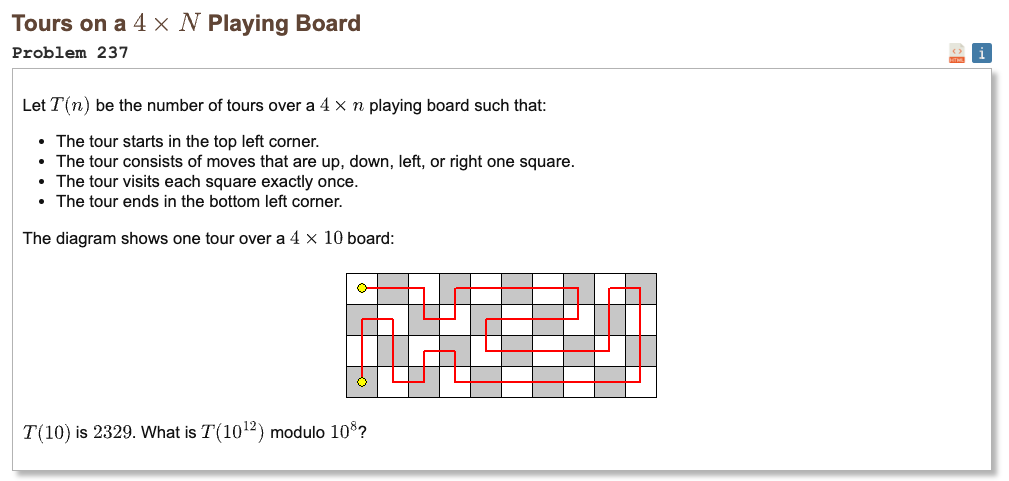

## Initial approach

* treat the 4×n tour as a single Hamiltonian path that uses every square once
* scan the board column by column, because height is fixed so the boundary between columns has only 4 positions
* on each boundary, keep a compact state that tells which rows have an open connection to the next column and which of those belong to the same partial path component
* also track whether a partial component is connected to the start square, the end square, or neither, so we know how the final path must close
* for one column, try all patterns of vertical edges inside the column and right edges going out, and enforce the degree rule at every cell (2 everywhere except the two endpoints in the first column)
* reject any transition that would create a closed loop too early, meaning a component with no open boundary connections before the last column
* this gives a fixed transition matrix for “regular” columns, so we can jump to huge n with matrix exponentiation
* handle the first column and the last column specially, first because of endpoint degrees, last because it is the only place where closing the final component is allowed

In [1]:
from math import isqrt

MOD = 10**8

class DSU:
    def __init__(self, n, flags):
        self.parent = list(range(n))
        self.rank = [0] * n
        self.flags = flags[:]

    def find(self, a):
        while self.parent[a] != a:
            self.parent[a] = self.parent[self.parent[a]]
            a = self.parent[a]
        return a

    def union(self, a, b):
        ra = self.find(a)
        rb = self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        self.flags[ra] |= self.flags[rb]
        if self.rank[ra] == self.rank[rb]:
            self.rank[ra] += 1

def canonical_from_components(row_roots, root_flags):
    comp_map = {}
    labels = [0, 0, 0, 0]
    flags_out = []
    next_id = 1
    for r in range(4):
        rt = row_roots[r]
        if rt is None:
            labels[r] = 0
        else:
            if rt not in comp_map:
                comp_map[rt] = next_id
                flags_out.append(root_flags[rt])
                next_id += 1
            labels[r] = comp_map[rt]
    return (tuple(labels), tuple(flags_out))

def iter_transitions_regular(state):
    labels_in, flags_in = state
    k = len(flags_in)
    L = [1 if labels_in[r] != 0 else 0 for r in range(4)]

    for mask_r in range(16):
        R = [(mask_r >> r) & 1 for r in range(4)]
        for mask_v in range(8):
            V = [(mask_v >> i) & 1 for i in range(3)]
            deg0 = L[0] + R[0] + V[0]
            deg1 = L[1] + R[1] + V[0] + V[1]
            deg2 = L[2] + R[2] + V[1] + V[2]
            deg3 = L[3] + R[3] + V[2]
            if deg0 != 2 or deg1 != 2 or deg2 != 2 or deg3 != 2:
                continue

            n_nodes = k + 4
            flags_init = [0] * n_nodes
            for i in range(k):
                flags_init[i] = flags_in[i]
            dsu = DSU(n_nodes, flags_init)

            for r in range(4):
                if L[r]:
                    comp_idx = labels_in[r] - 1
                    dsu.union(k + r, comp_idx)

            if V[0]:
                dsu.union(k + 0, k + 1)
            if V[1]:
                dsu.union(k + 1, k + 2)
            if V[2]:
                dsu.union(k + 2, k + 3)

            root_stub_count = {}
            for r in range(4):
                if R[r]:
                    rt = dsu.find(k + r)
                    root_stub_count[rt] = root_stub_count.get(rt, 0) + 1

            all_roots = set()
            for r in range(4):
                all_roots.add(dsu.find(k + r))
            for r in range(4):
                if L[r]:
                    all_roots.add(dsu.find(k + r))

            bad = False
            for rt in all_roots:
                if root_stub_count.get(rt, 0) == 0:
                    bad = True
                    break
            if bad:
                continue

            row_roots = [None, None, None, None]
            root_flags = {}
            for r in range(4):
                if R[r]:
                    rt = dsu.find(k + r)
                    row_roots[r] = rt
                    root_flags[rt] = dsu.flags[dsu.find(rt)]
            yield canonical_from_components(row_roots, root_flags)

def iter_transitions_first_column():
    for mask_r in range(16):
        R = [(mask_r >> r) & 1 for r in range(4)]
        for mask_v in range(8):
            V = [(mask_v >> i) & 1 for i in range(3)]
            deg0 = R[0] + V[0]
            deg1 = R[1] + V[0] + V[1]
            deg2 = R[2] + V[1] + V[2]
            deg3 = R[3] + V[2]
            if deg0 != 1 or deg3 != 1 or deg1 != 2 or deg2 != 2:
                continue

            flags_init = [1, 0, 0, 2]
            dsu = DSU(4, flags_init)

            if V[0]:
                dsu.union(0, 1)
            if V[1]:
                dsu.union(1, 2)
            if V[2]:
                dsu.union(2, 3)

            root_stub_count = {}
            for r in range(4):
                if R[r]:
                    rt = dsu.find(r)
                    root_stub_count[rt] = root_stub_count.get(rt, 0) + 1

            all_roots = set(dsu.find(r) for r in range(4))

            bad = False
            for rt in all_roots:
                if root_stub_count.get(rt, 0) == 0:
                    bad = True
                    break
            if bad:
                continue

            row_roots = [None, None, None, None]
            root_flags = {}
            for r in range(4):
                if R[r]:
                    rt = dsu.find(r)
                    row_roots[r] = rt
                    root_flags[rt] = dsu.flags[dsu.find(rt)]
            yield canonical_from_components(row_roots, root_flags)

def finish_contrib_last_column(state):
    labels_in, flags_in = state
    k = len(flags_in)
    L = [1 if labels_in[r] != 0 else 0 for r in range(4)]

    total = 0
    R = [0, 0, 0, 0]
    for mask_v in range(8):
        V = [(mask_v >> i) & 1 for i in range(3)]
        deg0 = L[0] + V[0]
        deg1 = L[1] + V[0] + V[1]
        deg2 = L[2] + V[1] + V[2]
        deg3 = L[3] + V[2]
        if deg0 != 2 or deg1 != 2 or deg2 != 2 or deg3 != 2:
            continue

        n_nodes = k + 4
        flags_init = [0] * n_nodes
        for i in range(k):
            flags_init[i] = flags_in[i]
        dsu = DSU(n_nodes, flags_init)

        for r in range(4):
            if L[r]:
                comp_idx = labels_in[r] - 1
                dsu.union(k + r, comp_idx)

        if V[0]:
            dsu.union(k + 0, k + 1)
        if V[1]:
            dsu.union(k + 1, k + 2)
        if V[2]:
            dsu.union(k + 2, k + 3)

        roots = set(dsu.find(k + r) for r in range(4))
        if len(roots) != 1:
            continue
        rt = next(iter(roots))
        if dsu.flags[dsu.find(rt)] != 3:
            continue

        total = (total + 1) % MOD

    return total

def mat_mul(A, B, mod):
    n = len(A)
    m = len(B[0])
    p = len(B)
    C = [[0] * m for _ in range(n)]
    for i in range(n):
        Ai = A[i]
        Ci = C[i]
        for k in range(p):
            aik = Ai[k]
            if aik:
                Bk = B[k]
                for j in range(m):
                    Ci[j] = (Ci[j] + aik * Bk[j]) % mod
    return C

def mat_pow(M, e, mod):
    n = len(M)
    R = [[0] * n for _ in range(n)]
    for i in range(n):
        R[i][i] = 1
    A = [row[:] for row in M]
    while e > 0:
        if e & 1:
            R = mat_mul(A, R, mod)
        A = mat_mul(A, A, mod)
        e >>= 1
    return R

def solve(n):
    if n == 1:
        ans = 0
        for labels, flags in iter_transitions_first_column():
            if labels == (0, 0, 0, 0) and len(flags) == 1 and flags[0] == 3:
                ans = (ans + 1) % MOD
        return ans

    init_counts = {}
    for st in iter_transitions_first_column():
        init_counts[st] = (init_counts.get(st, 0) + 1) % MOD

    seen = set(init_counts.keys())
    frontier = list(init_counts.keys())
    while frontier:
        st = frontier.pop()
        for nxt in iter_transitions_regular(st):
            if nxt not in seen:
                seen.add(nxt)
                frontier.append(nxt)

    states = list(seen)
    idx = {st: i for i, st in enumerate(states)}
    S = len(states)

    T = [[0] * S for _ in range(S)]
    for st in states:
        i = idx[st]
        for nxt in iter_transitions_regular(st):
            j = idx[nxt]
            T[j][i] = (T[j][i] + 1) % MOD

    v0 = [[0] for _ in range(S)]
    for st, c in init_counts.items():
        v0[idx[st]][0] = (v0[idx[st]][0] + c) % MOD

    if n == 2:
        v_mid = v0
    else:
        Tp = mat_pow(T, n - 2, MOD)
        v_mid = mat_mul(Tp, v0, MOD)

    ans = 0
    for st in states:
        i = idx[st]
        ways_to_finish = finish_contrib_last_column(st)
        if ways_to_finish:
            ans = (ans + v_mid[i][0] * ways_to_finish) % MOD
    return ans

In [2]:
%%time
N = 10**12
result = solve(N)
print("Result:", result)

Result: 15836928
CPU times: user 10.3 ms, sys: 355 μs, total: 10.7 ms
Wall time: 10.4 ms
